In [9]:
import math
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# (TSP 6 Ciudades de Ecuador)

In [10]:
 # Coordenadas (x, y) aproximadas y simplificadas para el cálculo.
ciudades_ecuador = {
    "Quito": (10, 80),
    "Guayaquil": (0, 50),
    "Cuenca": (20, 30),
    "Ambato": (15, 70),
    "Manta": (-20, 55),
    "Loja": (25, 10)
}

lista_ciudades = list(ciudades_ecuador.items())
indices_ciudades = list(range(len(lista_ciudades)))

def calcular_distancia(ciudad_a, ciudad_b):
    """Calcula la distancia euclidiana entre dos puntos (x, y)"""
    return np.sqrt((ciudad_a[0] - ciudad_b[0])**2 + (ciudad_a[1] - ciudad_b[1])**2)

def distancia_total(ruta, ciudades):
    """Calcula la distancia total de una ruta (lista de índices)"""
    distancia = 0
    for i in range(len(ruta)):
        idx_a = ruta[i]
        # Conecta la última ciudad con la primera
        idx_b = ruta[(i + 1) % len(ruta)]
        
        coord_a = ciudades[idx_a][1]
        coord_b = ciudades[idx_b][1]
        
        distancia += calcular_distancia(coord_a, coord_b)
    return distancia

def generar_vecino_2opt(ruta):
    """
    Genera una ruta vecina intercambiando dos ciudades (un "swap" simple).
    Esta es una forma de "2-opt", que es un movimiento común en TSP.
    """
    vecino = ruta[:] # Copiar la ruta
    # Selecciona dos índices aleatorios para intercambiar
    i, j = random.sample(range(len(vecino)), 2)
    vecino[i], vecino[j] = vecino[j], vecino[i]
    return vecino


# 1. IMPLEMENTACIÓN DE SIMULATED ANNEALING (SA) BÁSICO 


In [11]:
def simulated_annealing_basico(ciudades, indices_iniciales, temp_inicial, temp_min, tasa_enfriamiento, max_iter_por_temp):
    
    inicio_tiempo = time.time()
    
    ruta_actual = indices_iniciales[:]
    costo_actual = distancia_total(ruta_actual, ciudades)
    
    mejor_ruta = ruta_actual[:]
    mejor_costo = costo_actual
    
    temperatura = temp_inicial
    iteraciones_totales = 0
    
    while temperatura > temp_min:
        # Hacemos varias iteraciones en la misma temperatura
        for _ in range(max_iter_por_temp):
            iteraciones_totales += 1
            
            # 1. Generar un vecino
            ruta_vecina = generar_vecino_2opt(ruta_actual)
            costo_vecino = distancia_total(ruta_vecina, ciudades)
            
            # 2. Decidir si aceptar el vecino
            delta_costo = costo_vecino - costo_actual
            
            # Si el vecino es mejor (costo menor), siempre lo aceptamos
            if delta_costo < 0:
                ruta_actual = ruta_vecina
                costo_actual = costo_vecino
                
                # Actualizar la mejor solución global encontrada
                if costo_actual < mejor_costo:
                    mejor_ruta = ruta_actual
                    mejor_costo = costo_actual
            
            # Si el vecino es peor, lo aceptamos con una probabilidad basada en la temperatura (Fórmula de Boltzmann)
            else:
                probabilidad_aceptacion = math.exp(-delta_costo / temperatura)
                if random.random() < probabilidad_aceptacion:
                    ruta_actual = ruta_vecina
                    costo_actual = costo_vecino
        
        # 3. Enfriar la temperatura
        temperatura *= tasa_enfriamiento
        
    fin_tiempo = time.time()
    tiempo_ejecucion = fin_tiempo - inicio_tiempo
    
    return mejor_ruta, mejor_costo, iteraciones_totales, tiempo_ejecucion

# 2. IMPLEMENTACIÓN DE TABU SEARCH (TS) BÁSICO 

In [12]:
def tabu_search_basico(ciudades, indices_iniciales, max_iteraciones, tamano_lista_tabu, num_vecinos_a_explorar):
    
    inicio_tiempo = time.time()
    
    ruta_actual = indices_iniciales[:]
    costo_actual = distancia_total(ruta_actual, ciudades)
    
    mejor_ruta = ruta_actual[:]
    mejor_costo = costo_actual
    
    lista_tabu = [] # Usaremos una lista simple como cola FIFO
    
    for iteracion in range(max_iteraciones):
        
        mejor_vecino = None
        mejor_costo_vecino = float('inf')
        movimiento_del_mejor_vecino = None

        # 1. Explorar el vecindario (Para un TS real, se exploran *todos* los vecinos 2-opt, pero para una versión simple, exploramos un subconjunto)
        for _ in range(num_vecinos_a_explorar):
            
            # Generamos un "movimiento" (swap)
            i, j = random.sample(range(len(ruta_actual)), 2)
            # Aseguramos que i < j para estandarizar el movimiento
            movimiento = tuple(sorted((i, j))) 
            
            ruta_vecina = ruta_actual[:]
            ruta_vecina[i], ruta_vecina[j] = ruta_vecina[j], ruta_vecina[i]
            costo_vecino = distancia_total(ruta_vecina, ciudades)

            # 2. Verificar si el movimiento es Tabú
            # Y si es el mejor vecino encontrado *en esta iteración*
            if movimiento not in lista_tabu and costo_vecino < mejor_costo_vecino:
                mejor_vecino = ruta_vecina
                mejor_costo_vecino = costo_vecino
                movimiento_del_mejor_vecino = movimiento

        # 3. Criterio de Aspiración (simple)
        # Si el mejor vecino (aunque sea tabú) es MEJOR que la mejor solución global encontrada, lo aceptamos.  (En esta implementación simple, ya filtramos por tabú, pero si no lo hiciéramos, aquí iría esa lógica)
        
        # 4. Moverse a la mejor solución no-tabú
        if mejor_vecino is not None:
            ruta_actual = mejor_vecino
            costo_actual = mejor_costo_vecino
            
            # 5. Actualizar la lista Tabú (la "memoria")
            lista_tabu.append(movimiento_del_mejor_vecino)
            if len(lista_tabu) > tamano_lista_tabu:
                lista_tabu.pop(0) # Eliminar el movimiento más antiguo
            
            # 6. Actualizar la mejor solución global
            if costo_actual < mejor_costo:
                mejor_ruta = ruta_actual
                mejor_costo = costo_actual
        
        # Si no hay vecinos válidos (raro), nos detenemos
        else:
            break
            
    fin_tiempo = time.time()
    tiempo_ejecucion = fin_tiempo - inicio_tiempo
    
    return mejor_ruta, mejor_costo, max_iteraciones, tiempo_ejecucion

# 3. EJECUCIÓN Y REGISTRO DE RESULTADOS 

In [8]:
# Mezclar la ruta inicial para que no empiecen igual
ruta_inicial = indices_ciudades[:]
random.shuffle(ruta_inicial)

print("Problema: TSP 6 Ciudades de Ecuador")
ruta_nombres_inicial = [lista_ciudades[i][0] for i in ruta_inicial]
print(f"Ruta Inicial: {' -> '.join(ruta_nombres_inicial)}")
print(f"Distancia Inicial: {distancia_total(ruta_inicial, lista_ciudades):.2f}\n")

# --- Resultados Simulated Annealing ---
print("--- Ejecutando Simulated Annealing (Básico) ---")
sa_params = {
    "temp_inicial": 1000,
    "temp_min": 0.1,
    "tasa_enfriamiento": 0.99,
    "max_iter_por_temp": 50
}
sa_ruta, sa_costo, sa_iters, sa_tiempo = simulated_annealing_basico(
    lista_ciudades, 
    ruta_inicial, 
    **sa_params
)

ruta_nombres_sa = [lista_ciudades[i][0] for i in sa_ruta]
print(f"  Solución obtenida (Ruta): {' -> '.join(ruta_nombres_sa)}")
print(f"  Solución obtenida (Distancia): {sa_costo:.4f}")
print(f"  Iteraciones totales estimadas: {sa_iters}")
print(f"  Tiempo de ejecución: {sa_tiempo:.6f} segundos")

# --- Resultados Tabu Search ---
print("\n--- Ejecutando Tabu Search (Básico) ---")
ts_params = {
    "max_iteraciones": 200,
    "tamano_lista_tabu": 10,
    "num_vecinos_a_explorar": 20 # (N*(N-1))/2 sería explorar todo el vecindario 2-opt
}
ts_ruta, ts_costo, ts_iters, ts_tiempo = tabu_search_basico(
    lista_ciudades, 
    ruta_inicial, 
    **ts_params
)

ruta_nombres_ts = [lista_ciudades[i][0] for i in ts_ruta]
print(f"  Solución obtenida (Ruta): {' -> '.join(ruta_nombres_ts)}")
print(f"  Solución obtenida (Distancia): {ts_costo:.4f}")
print(f"  Iteraciones hasta converger (Max): {ts_iters}")
print(f"  Tiempo de ejecución: {ts_tiempo:.6f} segundos")

Problema: TSP 6 Ciudades de Ecuador
Ruta Inicial: Quito -> Cuenca -> Guayaquil -> Loja -> Manta -> Ambato
Distancia Inicial: 239.34

--- Ejecutando Simulated Annealing (Básico) ---
  Solución obtenida (Ruta): Loja -> Cuenca -> Ambato -> Quito -> Manta -> Guayaquil
  Solución obtenida (Distancia): 178.9438
  Iteraciones totales estimadas: 45850
  Tiempo de ejecución: 0.763450 segundos

--- Ejecutando Tabu Search (Básico) ---
  Solución obtenida (Ruta): Quito -> Manta -> Guayaquil -> Loja -> Cuenca -> Ambato
  Solución obtenida (Distancia): 178.9438
  Iteraciones hasta converger (Max): 200
  Tiempo de ejecución: 0.057315 segundos


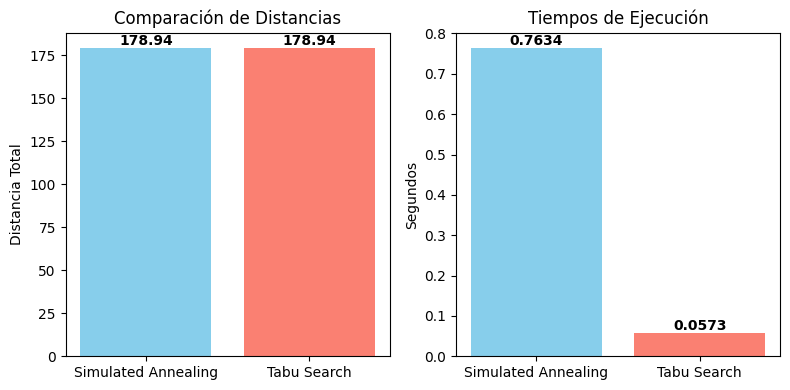

In [29]:
# --- Gráficos Comparativos ---
metodos = ['Simulated Annealing', 'Tabu Search']
distancias = [sa_costo, ts_costo]
tiempos = [sa_tiempo, ts_tiempo]

plt.figure(figsize=(8,4))

# --- Gráfico de distancias ---
plt.subplot(1,2,1)
barras1 = plt.bar(metodos, distancias, color=['skyblue','salmon'])
plt.title('Comparación de Distancias')
plt.ylabel('Distancia Total')

# Añadir etiquetas (nodos) arriba de las barras
for barra in barras1:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura + 0.05, 
             f'{altura:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Gráfico de tiempos ---
plt.subplot(1,2,2)
barras2 = plt.bar(metodos, tiempos, color=['skyblue','salmon'])
plt.title('Tiempos de Ejecución')
plt.ylabel('Segundos')

for barra in barras2:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura + 0.0005, 
             f'{altura:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()




